# Make this notebook run in IBM Watson

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

# Multiple Perceptron

A multilayer perceptron (MLP) is also known as a vanilla neural network because it is the core example of an architecture. The vanilla neural networks often only have a single hidden layer, but a MLP can have many more. The number of hidden layers and the size (number of nodes in each) are configurable parameters that you will need to keep in mind when building neural networks.

In [3]:
cos2file(project, '/images', 'multiple_perceptron.png')

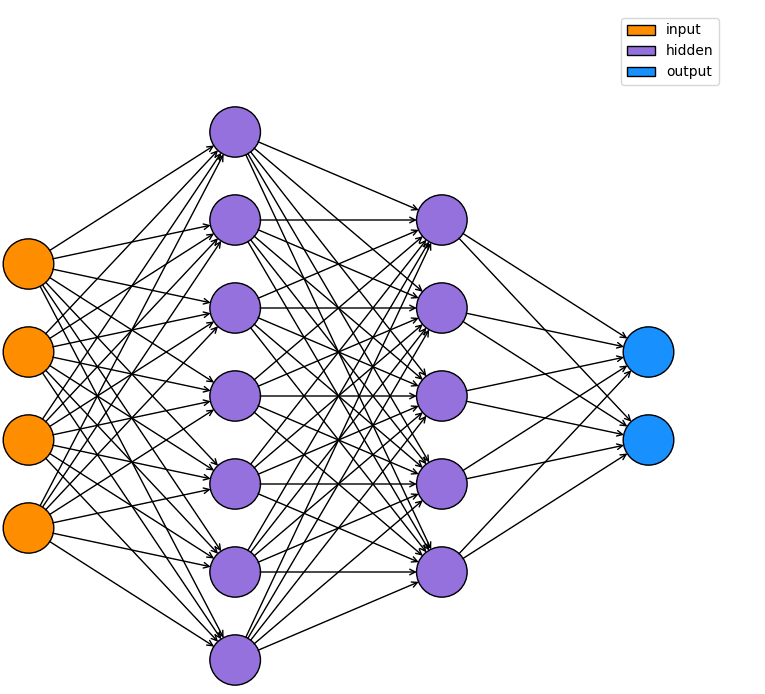

In [4]:
from IPython.display import Image
Image("../images/multiple_perceptron.png",width=800, height=600)

The layer all the way to the left is known as the **input layer** and it is comprised of neurons that represent the input features. In this architecture we include two **hidden layers**, the next layers to the right. Each neuron in the hidden layer transforms the values from the neurons connected from the previous layer. This is done using a weighted linear summation and a non-linear **activation function**. The **output layer** receives the values from the last hidden layer and transforms them into output values.

In [5]:
cos2file(project, '/data', 'aavail-target.csv')

In [6]:
import sys
import os
import re
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

In [7]:
def load_data():

    data_dir = os.path.join("..","data")
    df = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))

    ## pull out the target and remove uneeded columns
    _y = df.pop('is_subscriber')
    y = np.zeros(_y.size)
    y[_y==0] = 1 
    df.drop(columns=['customer_id','customer_name'],inplace=True)
    return(y,df)

In [8]:
## variables
rs = 42

## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [9]:
## load the data
y, df = load_data()
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rs)

In [10]:
pipe  = Pipeline(steps=[('preprocessor', preprocessor),
                        ('nn', MLPClassifier(alpha=1e-5,random_state=rs))])


param_grid = {
    'nn__activation': ['logistic', 'tanh', 'relu'],
    'nn__solver': ['lbfgs', 'sgd','adam'],
    'nn__hidden_layer_sizes': [(10,10),(50,50),(100,100),(50,50,50),(100,100,100)]
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

## extract feature names
pipe.fit(X_train, y_train)
feature_names = np.hstack([numeric_features,
                           preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names()])

feature_names = [re.sub("x\d_","",fn) for fn in feature_names]
target_names = ['subscriber','churned']
print(feature_names)
print(classification_report(y_test, y_pred, target_names=target_names))

['age', 'num_streams', 'singapore', 'united_states', 'aavail_basic', 'aavail_premium', 'aavail_unlimited']
              precision    recall  f1-score   support

  subscriber       0.83      0.90      0.86       142
     churned       0.70      0.55      0.62        58

   micro avg       0.80      0.80      0.80       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.79      0.80      0.79       200



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [11]:
!pip install joblib

In [12]:
import joblib
import time

saved_model = 'my-saved-model.joblib'
if not os.path.exists(saved_model):
    time_start = time.time()
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train, y_train)
    joblib.dump(grid, saved_model)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_model))
    grid = joblib.load(saved_model)

## print best parameters
print(grid.best_params_)

loading my-saved-model.joblib from file
{'nn__activation': 'logistic', 'nn__hidden_layer_sizes': (50, 50, 50), 'nn__solver': 'adam'}


Notable types of artificial neural networks:

**Multi-layer perceptron**
>Feed-forward neural network used for supervised learning. Often uses multiple layers and non-linear activation functions. Can be applied to most supervised learning tasks.

**Autoencoders**
> It is a feed forward neural network that can be used to predict the feature matrix. Autoencoders may be thought of as being a special case of feedforward network used for unsupervised learning tasks. Example applications include dimension reduction and de-noising.

**Convolutional neural network**
> A convolutional neural network (CNN, or ConvNet) uses image filters or kernels to learn patterns in a feature matrix. Commonly used to detect patterns in images and video.

**Recurrent neural network**
> In RNNs connections between nodes can be cyclical, giving the network memory. Used for sequences: handwriting, speech recognition, time series. One commonly used RNN architecture is the long short-term memory.

# A simple Neural Network in TensorFlow

Train a RandomForest to compare the results

In [13]:
from sklearn.ensemble import RandomForestClassifier

params = {"n_estimators":100, "max_depth":2}
clf = RandomForestClassifier(**params)
pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", clf)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       142
         1.0       0.71      0.55      0.62        58

   micro avg       0.81      0.81      0.81       200
   macro avg       0.77      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200



In [14]:
import tensorflow as tf
from tensorflow import keras

In [15]:
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

print(X_train_pre.shape)

(800, 7)


In [16]:
model = keras.Sequential([
    keras.layers.Dense(15, activation="relu", input_shape=X_train_pre.shape[1:]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation="softmax")
])

## compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.fit(X_train_pre, y_train, epochs=10, validation_data=(X_test_pre, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 23s 29ms/sample - loss: 0.6431 - acc: 0.7013 - val_loss: 0.6209 - val_acc: 0.7100
Epoch 2/10
800/800 [==============================] - 25s 31ms/sample - loss: 0.6215 - acc: 0.7100 - val_loss: 0.5982 - val_acc: 0.7100
Epoch 3/10
800/800 [==============================] - 29s 36ms/sample - loss: 0.6090 - acc: 0.7175 - val_loss: 0.5812 - val_acc: 0.7100
Epoch 4/10
800/800 [==============================] - 28s 35ms/sample - loss: 0.5889 - acc: 0.7175 - val_loss: 0.5708 - val_acc: 0.7100
Epoch 5/10
800/800 [==============================] - 26s 33ms/sample - loss: 0.5779 - acc: 0.7212 - val_loss: 0.5563 - val_acc: 0.7050
Epoch 6/10
800/800 [==============================] - 28s 35ms/sample - loss: 0.5641 - acc: 0.7362 - val_loss: 0.5445 - val_acc: 0.7100
Epoch 7/10
800/800 [==============================] - 32s 40ms/sample - loss: 0.5574 - acc: 0.7375 - val_loss: 0.5336 - val_acc: 0.7300
Ep

In [18]:
y_pred = model.predict(X_test_pre)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.95      0.84       142
         1.0       0.68      0.26      0.38        58

   micro avg       0.75      0.75      0.75       200
   macro avg       0.72      0.60      0.61       200
weighted avg       0.74      0.75      0.71       200



## Model Persistance

In [19]:
# save the model
model.save("saved_model.h5")
loaded_model = keras.models.load_model("saved_model.h5")

In [20]:
## create checkpoint directory
if not os.path.isdir("checkpoints"):
    os.mkdir("checkpoints")

# Include the epoch in the file names
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0)

# Train the model with the new callback
history = model.fit(X_train_pre, y_train, epochs=10, callbacks=[cp_callback], 
                    validation_data=(X_test_pre, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 30s 37ms/sample - loss: 0.5449 - acc: 0.7588 - val_loss: 0.5062 - val_acc: 0.7600
Epoch 2/10
800/800 [==============================] - 28s 35ms/sample - loss: 0.5175 - acc: 0.7600 - val_loss: 0.5035 - val_acc: 0.7600
Epoch 3/10
800/800 [==============================] - 30s 38ms/sample - loss: 0.5062 - acc: 0.7800 - val_loss: 0.4978 - val_acc: 0.7850
Epoch 4/10
800/800 [==============================] - 29s 37ms/sample - loss: 0.5184 - acc: 0.7650 - val_loss: 0.4986 - val_acc: 0.7800
Epoch 5/10
800/800 [==============================] - 29s 36ms/sample - loss: 0.5268 - acc: 0.7575 - val_loss: 0.5043 - val_acc: 0.7750
Epoch 6/10
800/800 [==============================] - 29s 36ms/sample - loss: 0.5156 - acc: 0.7725 - val_loss: 0.5013 - val_acc: 0.7800
Epoch 7/10
800/800 [==============================] - 30s 37ms/sample - loss: 0.5057 - acc: 0.7900 - val_loss: 0.4978 - val_acc: 0.7900
Ep